# Value at risk - aggregation

In this notebook, we show how to
- retrieve all monte carlo experiments computed at previous stage
- aggregate experiments at a portfolio level
- compute VaR on-demand for historical or point in time data through user aggregated function
- supercharge your var calculation with news event data

### Authors
- Antoine Amend [<antoine.amend@databricks.com>]

# `STEP0` Configuration

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
from datetime import datetime, timedelta
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.sql import functions as F

In [4]:
portfolio_table = 'var_portfolio'
stock_table = 'var_stock'
stock_return_table = 'var_stock_return'
market_table = 'var_market'
market_return_table = 'var_market_return'
trial_table = 'var_monte_carlo'

In [5]:
%scala

//number of simulations
val runs = 50000

//value at risk confidence
val confidenceVar = 95

runs: Int = 50000
confidenceVar: Int = 95

In [6]:
try:
  dbutils.widgets.remove('run')
except:
  print('No widget named [run]')

all_runs = sql("SELECT DISTINCT run_date FROM {}".format(trial_table)).toPandas()['run_date']
dbutils.widgets.dropdown("run", all_runs[0], all_runs)

/databricks/spark/python/pyspark/sql/types.py:1636: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
 return pa.schema(fields)

# `STEP1` Compute value at risk

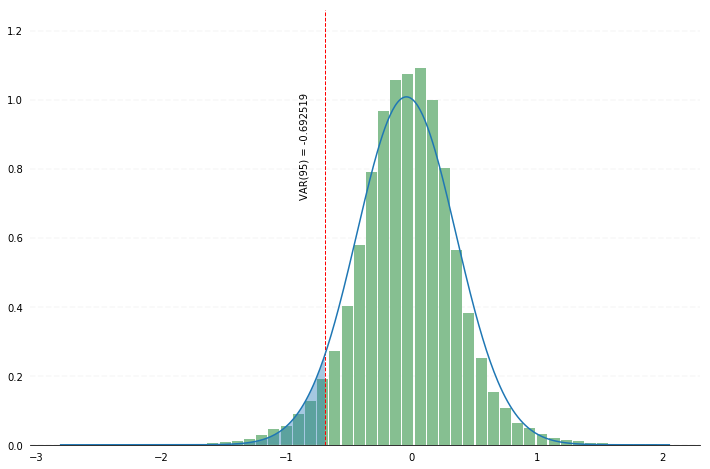

In [8]:
run = dbutils.widgets.get('run')

# aggregate monte carlo simulations
mc_df = spark \
  .read \
  .table(trial_table) \
  .filter(F.col('run_date') == run) \
  .withColumnRenamed('trial', 'return') \
  .groupBy('seed') \
  .agg(F.sum('return').alias('return')) \
  .select('return') \
  .toPandas()

returns = mc_df['return']

# compute 95 value at risk
value_at_risk = np.quantile(returns, 5 / 100)
mc_df['exceeds'] = mc_df['return'] > value_at_risk

# extract normal distribution
avg = returns.mean()
std = returns.std()
x1 = np.arange(returns.min(),returns.max(),0.01)
y1 = stats.norm.pdf(x1, loc=avg, scale=std)
x2 = np.arange(returns.min(),value_at_risk,0.001)
y2 = stats.norm.pdf(x2, loc=avg, scale=std)

# plot value at risk
ax = mc_df.hist(column='return', bins=50, density=True, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:
  
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    x.axvline(x=value_at_risk, color='r', linestyle='dashed', linewidth=1)
    x.fill_between(x2, y2, zorder=3, alpha=0.4)
    x.plot(x1, y1, zorder=3)
    
    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    x.text(value_at_risk - 0.2, 1, "VAR(95) = {:2f}".format(value_at_risk), rotation=90)
    x.set_title('')
    x.set_ylabel('')
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


# `STEP2` Slice and dice value at risk

In [10]:
%scala

import org.apache.spark.sql.SparkSession
import org.apache.spark.sql.expressions.MutableAggregationBuffer
import org.apache.spark.sql.expressions.UserDefinedAggregateFunction
import org.apache.spark.sql.Row
import org.apache.spark.sql.types._

class ValueAtRisk(n: Int) extends UserDefinedAggregateFunction {

  // This is the input fields for your aggregate function.
  override def inputSchema: org.apache.spark.sql.types.StructType = StructType(StructField("value", DoubleType) :: Nil)

  // This is the internal fields you keep for computing your aggregate.
  override def bufferSchema: StructType = StructType(Array(StructField("worst", ArrayType(DoubleType))))

  // This is the output type of your aggregatation function.
  override def dataType: DataType = DoubleType

  // The order we process dataframe does not matter, the worst will always be the worst
  override def deterministic: Boolean = true

  // This is the initial value for your buffer schema.
  override def initialize(buffer: MutableAggregationBuffer): Unit = {
    buffer(0) = Seq.empty[Double]
  }

  // This is how to update your buffer schema given an input.
  override def update(buffer: MutableAggregationBuffer, input: Row): Unit = {
    buffer(0) = buffer.getAs[Seq[Double]](0) :+ input.getAs[Double](0)
  }

  // This is how to merge two objects with the bufferSchema type.
  // We only keep worst N events
  override def merge(buffer: MutableAggregationBuffer, row: Row): Unit = {
    buffer(0) = (buffer.getAs[Seq[Double]](0) ++ row.getAs[Seq[Double]](0)).sorted.take(n)
  }

  // This is where you output the final value, given the final value of your bufferSchema.
  // Our value at risk is best of the worst n overall
  override def evaluate(buffer: Row): Any = {
    return buffer.getAs[Seq[Double]](0).sorted.last
  }

}

// Assume we've generated 50,000 monte-carlo simulations for each instrument
val numRecords = runs

// We want to compute Var(95)
val confidence = confidenceVar

// So the value at risk is the best of the worst N events 
val n = (100 - confidence) * numRecords / 100

// Register UADFs
val valueAtRisk = new ValueAtRisk(n)
spark.udf.register("VALUE_AT_RISK", new ValueAtRisk(n))

import org.apache.spark.sql.SparkSession
import org.apache.spark.sql.expressions.MutableAggregationBuffer
import org.apache.spark.sql.expressions.UserDefinedAggregateFunction
import org.apache.spark.sql.Row
import org.apache.spark.sql.types._
defined class ValueAtRisk
numRecords: Int = 50000
confidence: Int = 95
n: Int = 2500
valueAtRisk: ValueAtRisk = ValueAtRisk@1df3511a
res0: org.apache.spark.sql.expressions.UserDefinedAggregateFunction = ValueAtRisk@9d8df43

In [11]:
%sql
SELECT COUNT(*) FROM var_monte_carlo

count(1)
54250000


In [12]:
%sql
CREATE OR REPLACE TEMPORARY VIEW total_var AS 
SELECT 
  t.run_date AS day, 
  VALUE_AT_RISK(t.return) AS value_at_risk
FROM 
  (
  SELECT 
    m.run_date, 
    m.seed, 
    sum(m.trial) AS return
  FROM
    var_monte_carlo m
  GROUP BY
    m.run_date, 
    m.seed 
  ) t
GROUP BY 
  t.run_date
ORDER BY t.run_date ASC;

SELECT * FROM total_var

day,value_at_risk
2019-09-01,-0.6928858868777752
2019-09-08,-0.7049119093280751
2019-09-15,-0.6925233764341101
2019-09-22,-0.7090733400546014
2019-09-29,-0.7231321959989145
2019-10-06,-0.7648791784886271
2019-10-13,-0.7804052046267316
2019-10-20,-0.7695065723964944
2019-10-27,-0.7564442144939676
2019-11-03,-0.6968465845566243


In [13]:
%sql
OPTIMIZE var_monte_carlo ZORDER BY (country, industry)

path,metrics
null,"List(0, 0, List(null, null, 0.0, 0, 0), List(null, null, 0.0, 0, 0), 0, List(minCubeSize(107374182400), List(35, 233984079), List(0, 0), 1, List(0, 0), 0), 0)"


In [14]:
%sql

CREATE OR REPLACE TEMPORARY VIEW country_var AS 
SELECT 
  t.run_date AS day, 
  LOWER(t.country) AS country,
  VALUE_AT_RISK(t.return) AS value_at_risk
FROM 
  (
  SELECT 
    m.run_date, 
    m.seed, 
    m.country, 
    sum(m.trial) AS return
  FROM
    var_monte_carlo m
  GROUP BY
    m.run_date, 
    m.seed, 
    m.country
  ) t
GROUP BY 
  t.run_date, 
  t.country
ORDER BY t.run_date ASC;

SELECT * FROM country_var;

day,country,value_at_risk
2019-09-01,mexico,-0.25286372192204
2019-09-01,colombia,-0.1493275638204068
2019-09-01,panama,-0.04926716350018978
2019-09-01,peru,-0.13836429687216878
2019-09-01,chile,-0.1908803405240178
2019-09-08,colombia,-0.15000973269343376
2019-09-08,mexico,-0.2547118002548814
2019-09-08,peru,-0.14049983397126198
2019-09-08,panama,-0.049254484474658966
2019-09-08,chile,-0.19397717964602634


In [15]:
%sql
CREATE OR REPLACE TEMPORARY VIEW peru_var AS 
SELECT 
  t.run_date AS day, 
  LOWER(t.industry) AS industry,
  VALUE_AT_RISK(t.return) AS value_at_risk
FROM 
  (
  SELECT 
    m.run_date, 
    m.seed, 
    m.industry, 
    sum(m.trial) AS return
  FROM
    var_monte_carlo m
  WHERE
    m.country = 'PERU'
  GROUP BY
    m.run_date, 
    m.seed, 
    m.industry
  ) t
GROUP BY 
  t.run_date, 
  t.industry
ORDER BY t.run_date ASC;

CREATE OR REPLACE TEMPORARY VIEW peru_var_contribution AS
SELECT c.day, c.industry, c.value_at_risk / t.value_at_risk AS contribution
FROM peru_var c
JOIN (
  SELECT day, SUM(value_at_risk) AS value_at_risk
  FROM peru_var
  GROUP BY day
) t
WHERE c.day = t.day;

SELECT 
  c.day,
  c.industry,
  ABS(c.contribution * t.value_at_risk) AS contribution
FROM peru_var_contribution c
JOIN total_var t
WHERE t.day = c.day
ORDER BY t.day;

day,industry,contribution
2019-09-01,banks,0.09761273191919587
2019-09-01,industrial metals & mining,0.2684756029543246
2019-09-01,mining,0.18297690847259065
2019-09-01,construction & materials,0.14382064353166407
2019-09-08,industrial metals & mining,0.27145870450370807
2019-09-08,mining,0.1826312696101159
2019-09-08,banks,0.10012894630412475
2019-09-08,construction & materials,0.15069298891012642
2019-09-15,mining,0.1816898183119892
2019-09-15,construction & materials,0.14792984503748535


In [16]:
displayHTML('https://www.mining-technology.com/wp-content/uploads/sites/8/2019/08/Quellaveco_Project.jpg')

https://www.mining-technology.com/wp-content/uploads/sites/8/2019/08/Quellaveco_Project.jpg

# `HOMEWORK` Expected shortfall

We consider an investment of 1$ for each instrument here. 
How would you adapt above code to return [expected shortfall](https://en.wikipedia.org/wiki/Expected_shortfall) (in dollar value) instead of value at risk?